In [14]:
% matplotlib inline
from plot_setup import *
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("tab10",10)
#sns.palplot(sns.color_palette("tab10",10))

In [15]:
# include unbiased mock
fname_mem = "mock_mem_v002.csv"
fname_fg = "mock_fg_v002.csv"

mem = pd.read_csv(fname_mem)
fg = pd.read_csv(fname_fg)
mem["kind"],fg["kind"]="mem","fg"
tot = pd.concat((mem,fg),ignore_index=True)

In [4]:
tot

,R,v,kind
0,69.071132,21.107835,mem
1,47.458674,74.796463,mem
2,39.174235,43.688523,mem
3,52.957363,43.287517,mem
4,96.535116,64.450879,mem
5,107.571157,36.668118,mem
6,99.756841,49.357654,mem
7,54.254661,53.846435,mem
8,78.751471,59.718062,mem
9,80.516576,39.080576,mem


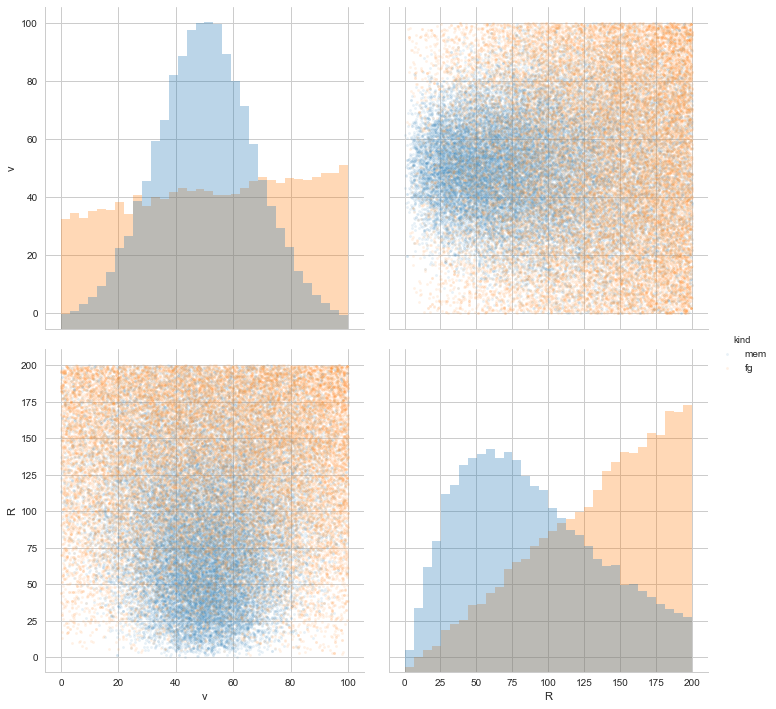

In [16]:
sns.pairplot(tot,vars=("v","R"),hue="kind",hue_order=("mem","fg"),size=5,plot_kws={"s":8,"marker":"o","alpha":0.1},diag_kws={"bins":32,"histtype":"stepfilled","alpha":0.3,"stacked":False})

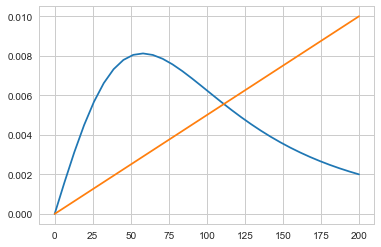

In [20]:
import model_definition as model
from scipy.integrate import quad

def prob_R_mem(R):
    # this is approximation!! (v and R are correlated, 
    # but most of stars are in RoI_v, so integration of Gauss_v is almost 1.
    #
    # \int_0^{R_max} 2*\pi*R * (1+(R/r_e)^2)^{-2} = pi/((1./R_max**2)+(1./r_e**2))
    r_e = model.initial_parameters_mem["r_e"]
    prob = 2*R/r_e**2/(1+(R/r_e)**2)**2 # 2*np.pi*R/np.pi/r_e**2/(1+(R/r_e)**2)**2
    norm = 1/(1+(r_e/model.RoI_R)**2) # integrate prob from 0 to RoI_R
    return prob/norm

def prob_R_fg(R):
    # integrate 2*np.pi*R*
    return 2*np.pi*R/np.pi/model.RoI_R**2

Rs = np.linspace(0,200,32)
plt.plot(Rs,prob_R_mem(Rs))
plt.plot(Rs,prob_R_fg(Rs))

# Create biased Mock

In [117]:
# separete Rs
n_separete = 32
mock = pd.DataFrame(tot,copy=True)
mock = mock.sort_values("R")
# set axes as (axis_bin,axis_R)
bin_edges = np.linspace(0,model.RoI_R,n_separete)[:,np.newaxis] 
Rs = np.array(mock.R)[np.newaxis,:]
# isin_nth_bin (axis_bin,axis_R)
isin_nth_bin = np.logical_and(bin_edges[:-1]<=Rs,Rs<bin_edges[1:])
isin_nth_bin.sum(axis=1)

array([ 157,  478,  762, 1019, 1343, 1473, 1570, 1733, 1746, 1881, 1784,
       2019, 1894, 1899, 1930, 1870, 1873, 1820, 1796, 1765, 1792, 1837,
       1933, 1857, 1888, 1838, 1930, 1849, 1984, 1938, 1946])

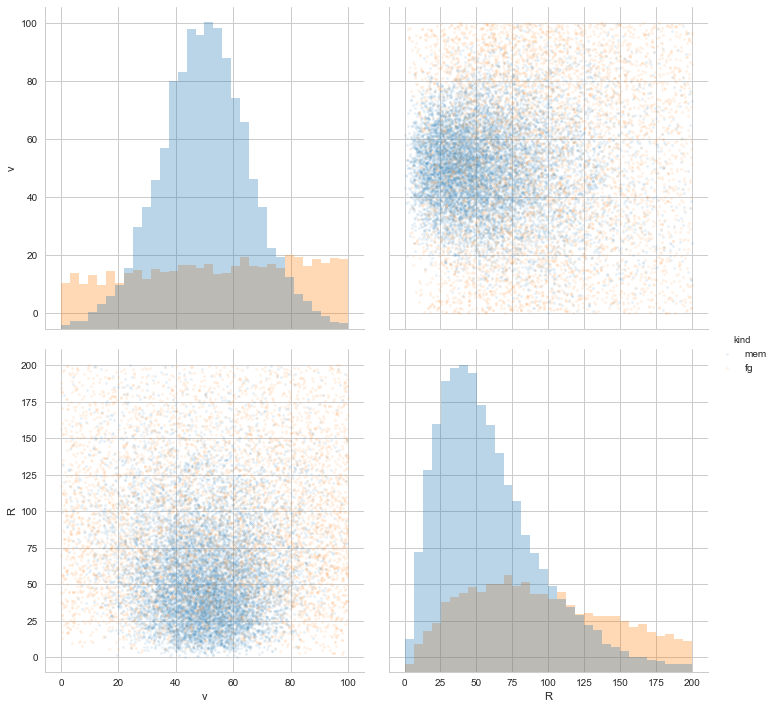

In [137]:
import random

#n_sampling_list = (np.arange(31)+1)*60
#fname_sampled = "mock_flatten_sampled_v002.csv"

n_sampling_list = np.round(prob_R_mem((bin_edges[:-1]+bin_edges[1:]/2).flatten()) * 1.4e5).astype(int)
fname_sampled = "mock_plummerlike_sampled_v002.csv"

if np.any(n_sampling_list > (isin_nth_bin.sum(axis=1))):
    mes = "n_sampled:" + str(n_sampling_list) + "\n"
    mes += "n_isin_nth_bin:" + str(isin_nth_bin.sum(axis=1))
    plt.plot(n_sampling_list,label="n_sampled")
    plt.plot(isin_nth_bin.sum(axis=1),label="n_isin_nth_bin")
    plt.legend()
    raise TypeError("too many sampling!\n"+str(n_sampling_list > (isin_nth_bin.sum(axis=1)))+"\n"+mes)
n_bins = len(isin_nth_bin)

# ind_list: (axis_bin, axis_sampled_ind)
ind_list = [random.sample(range(num_in_ith_bin),n_sampling) for n_sampling,num_in_ith_bin in zip(n_sampling_list,isin_nth_bin.sum(axis=1))] 
sampled_list = [(mock[isin_nth_bin[i]].iloc[ind_list[i]]).sort_values("R") for i in range(n_bins)]
mock_sampled = pd.concat(sampled_list)
sns.pairplot(
    mock_sampled,
    vars=("v","R"),hue="kind",hue_order=("mem","fg"),size=5,
    plot_kws={"s":8,"marker":"o","alpha":0.1},
    diag_kws={"bins":32,"histtype":"stepfilled","alpha":0.3,"stacked":False}
)

In [138]:
mock_sampled.to_csv(fname_sampled)